[Table of contents](../toc.ipynb)

# A machine learning model of a electric vehicle power train

The steps herein are similar to a recent paper of mine [[Rhode2020]](../references.bib), were online machine learning was used to create a power prediction model for an electric vehicle.

Given map data and a planned velocity profile, this prediction model can be used to estimate electric power and energy.

## Vehicle black box model

First, we start with some fundamentals in vehicle science.

The instantaneous tractive force reads

$
F_{t} = m_V \dot{v_{t}} + f_r m_V g \cos \theta_{t} + m_V g \sin \theta_{t} + \frac{\rho}{2} c_w A_V v_t^2,
$

and the instantaneous power
$
p_t = F_t v_t.
$

The summands in first equation are also known as acceleration force, rolling resistance, climbing force, and aerodynamic resistance, respectively.

Note that the velocity and acceleration plays an important role in most terms. With this in mind, we can come up with a black box model.

<img src="e-vehicle-model.png" alt="e-vehicle-model" width="450" align="right">

The right hand side figure illustrates the adopted non-linear black-box vehicle model,
$p_t \approx f(v_t, {a_x}_t)$

which includes two measured inputs, the velocity ($v_t$) and longitudinal acceleration ($a_x$), and the measured output power ($p$), being the product of the measured electric current and voltage. Our objective is to approximate the unknown non-linear function $f(\cdot)$ of the model equation given the measurements $v_t, {a_x}_t$, and $p_t$.

Note that the body fixed acceleration sensor considers road angle influence.

${a_x}_t  =  \dot{v}_t + g \sin \theta_t$

## Data record

The electric vehicle was propelled by two electric engines and their current and voltage was recorded at 100 Hz. Additionally, longitudinal acceleration and velocity from CAN bus signals as well as break pressure form disc brakes were stored.

All raw signals were smoothed with a Savitzky-Golay filter (window size 50) and down-sampled to 2 Hz.

Additionally, driving states with break pressure > 0 were removed from data because the black box model does not consider mechanical braking.

### First, let us examine the data 
There are three `.mat` files called `dat1.mat`, `dat2.mat`, and `dat3.mat`.
After a quick fix for missing path error in Travis - not needed for running Jupyter locally - we will import the data with `scipy.io.loadmat`.

In [1]:
# This if else is a fix to make the file available for Jupyter and Travis CI
import os


def find_mat(filename):
    if os.path.isfile(filename):
        file = filename
    else:
        file = '04_mini-projects/' + filename
    return file

In [2]:
import scipy.io
dat1 = scipy.io.loadmat(find_mat('dat1.mat'))

Let us take a look at the keys of the data and the dimensions.

In [3]:
dat1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A', 'Aval', 'B', 'Bval', 'k', 'm'])

In [4]:
print(dat1['A'].shape)
print(dat1['B'].shape)
print(dat1['Aval'].shape)
print(dat1['Bval'].shape)
print(dat1['k'])
print(dat1['m'])

(2204, 2)
(2204, 1)
(200, 2)
(200, 1)
[[200]]
[[2204]]


Now, you need some background information about the data. The field names `A` and `Aval` mean input data and validation input data. The shape of the `A` is 2204 times 2, which means 2204 measurement of two inputs. Actually, `Aval` contains of the last 200 samples of `A`. So be cautious to train any model just with `A` up to the last 200 samples. `B` and `Bval` are the respective outputs.

You might ask, why is the data not nice and clearly defined like in many sklearn tutorials with `X_train`, `X_test`, ...?

Because it is very common to spend much time with data cleansing of messy data in practice.

#### Exercise:  Data wrangling 

<img src="../_static/exercise.png" alt="Exercise" width="75" align="left">


Therefore, the first task for you is to:
* Write a function which load one of the `.mat` files,
* returns X_train, X_test, y_train, y_test given an argument of test size in samples.
We will just split the data, no shuffling here.

#### Solution
One possible function is defined in [solution_load_measurement](solution_load_measurement.py).

In [5]:
import sys
sys.path.append("04_mini-projects")

from solution_load_measurement import *

In [6]:
X_train, y_train, X_test, y_test = load_measurement('dat1.mat', test_size=400)

And to check if the split worked, we will compare `X_test` with the original `dat1['A']` and `y_test` with original `dat1['B']`.

In [16]:
print(X_test[0:5])

[[ 7.67722072 -0.29767279]
 [ 7.80163914 -0.29484879]
 [ 7.96368164 -0.48968736]
 [ 7.89868767 -0.70230645]
 [ 7.78985504 -0.68732839]]


In [17]:
print(dat1['A'][-400:-395])

[[ 7.67722072 -0.29767279]
 [ 7.80163914 -0.29484879]
 [ 7.96368164 -0.48968736]
 [ 7.89868767 -0.70230645]
 [ 7.78985504 -0.68732839]]


In [18]:
print(y_test[0:5])

[[ -420.61029092]
 [ -342.24263429]
 [-2112.49021421]
 [-4496.25616576]
 [-4598.45211968]]


In [19]:
print(dat1['B'][-400:-395])

[[ -420.61029092]
 [ -342.24263429]
 [-2112.49021421]
 [-4496.25616576]
 [-4598.45211968]]


### And now let us plot the data

#### Exercise: Plot the data

<img src="../_static/exercise.png" alt="Exercise" width="75" align="left">

The first column of `X_train` and `X_test` is the velocity in meter per second and the second column is the acceleration. `y_train` and `y_test` contain the electric power. Now, please plot the data in three panels where the training and test data are shown together (over samples) with different markers or colors.

#### Solution
I prefer to use a function because we have three data sets and my plot is defined in [solution_plot_data](solution_plot_data.py).

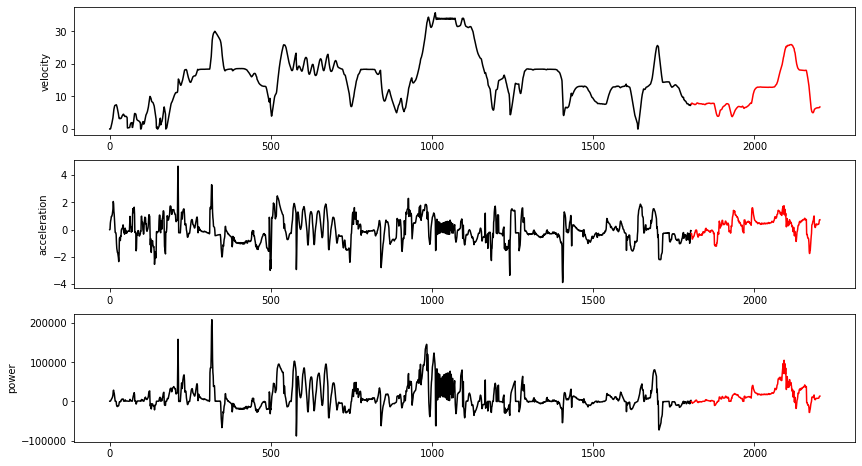

In [11]:
from solution_plot_data import *

plot_data(X_train, y_train, X_test, y_test)

## Modeling with different regression methods

<img src="adaptive-filter.png" alt="adaptive filter" width="400" align="right">

In the original paper, Recursive Least Squares (an adaptive filter form of linear regression), Kernel adaptive filters (a special kind of non-linear adaptive filter), and Neural Networks were compared. We cannot go into details of adaptive filtering herein, but very briefly, these methods provide solutions for a regression problem in an iterative way.

At every time step a regression result is returned. This makes adaptive filters ideal for tracking of time variant systems and when data receives as data stream, see figure on the right.

Next, we will train a **Linear Model** and  a **Gaussian Process** with sklearn in the sequel.

### Linear Model
The fit of the linear model is done with a few lines of code.

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X=X_train, y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Gaussian Process
Same holds for the Gaussian Process.

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(n_restarts_optimizer=20)
gp.fit(X=X_train, y=y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=20, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

### Compare both models with mean squared error

In [14]:
from sklearn.metrics import mean_squared_error

print("mse Linear Model \t", mean_squared_error(y_test, lin_reg.predict(X_test)))
print("mse GP \t\t\t", mean_squared_error(y_test, gp.predict(X_test)))

mse Linear Model 	 85914421.79698046
mse GP 			 49813117.43331423


The mean squared error of the GP is way smaller than the error of the linear model. Note that the linear model tries to model the problem with just two parameters, because `X_train` has herein two columns (or two sensor measurements). 

### Let us plot the predictions and compare them with the test data

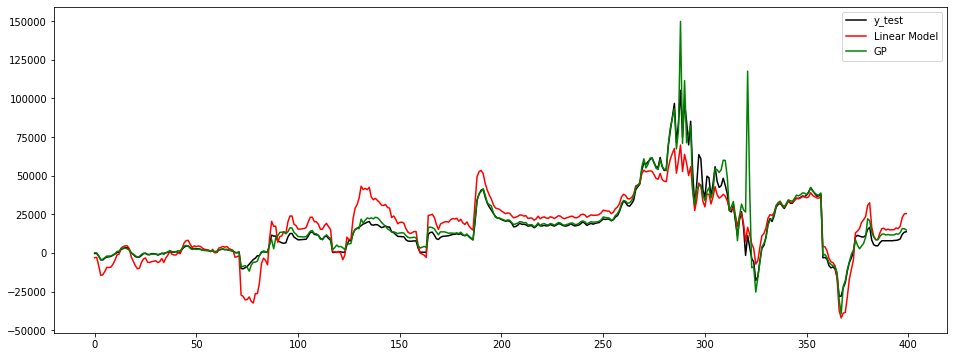

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(y_test, 'k')
plt.plot(lin_reg.predict(X_test), 'r')
plt.plot(gp.predict(X_test), 'g')
plt.legend(['y_test', 'Linear Model', 'GP'])

We can see that the Linear Model overshoots the test data in many areas where the GP is more accurate. However, the GP seems to have problem with high frequent dynamics as you can see between 250 and 350 samples.

## Sum up and a challenge for you

You hopefully also experienced here that the actual machine learning task took just a few lines of code. The major part was at the beginning where we thought how to set up the model. 

* What are the inputs and outputs?
* How do we have to pre-process the data?
* Which metric or plot do we use to examine the quality of the model?
* ...

This large effort in pre-processing and thinking about the problem we want to solve is very common. Therefore, if you are good in abstraction of problems, modeling and machine learning should be good fields for you to enter.

### Challenge: Adaptive Filters

<img src="../_static/exercise.png" alt="Exercise" width="75" align="left">

* Try to find a Python toolbox which contains adaptive filters and train a filter in a loop over `X_train` like in this pseudo code.

```python
for sample in X_train:
    filter.fit(sample)
```

* Use the last trained state of the filter and predict the power for the test set `y_test`.

* Use the other two data records `dat2.mat` and `dat3.mat` to cross validate all models.

* Try other regression methods from sklearn toolbox.